<a href="https://colab.research.google.com/github/quangsonle/MountainCar_ActorCritic/blob/master/sightbit_interview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyyaml==5.1
# This is the current pytorch version on Colab. Uncomment this if Colab changes its pytorch version
# !pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html

# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 4.3 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44091 sha256=264e541b442ae75e0cb50971071beba0eedaf6e40129baed6341dfcd454836cb
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
     |████████████████████████████████| 6.4 MB 645 kB/s 
     |████████████████████████████████| 49 kB 2.4 MB/s 
     |████████████████████████████████| 74 kB 2.1 MB/s 
     |████████████████████████████████| 144 kB 20.1 MB/s 
     |████████████████████████████████| 130 kB 27.6 MB/s 
     |████████████████████████████████| 721 kB 24.9 MB/s 
     |████████████████████████████████| 743 kB 48.4 MB/s 
     |██

In [ ]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9")   # please manually install torch 1.9 if Colab changes its default version

1.9.0+cu102 False


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:

im = cv2.imread("./beach2.jpg")


# horizon detection
#GLOBAL OBJECTIVE SETTINGS

global_img_reduction = 0.1
global_angles = (-90,91,5)
global_distances = (5,100,5) 
global_buffer_size = 3
import two_objectives_horizon_detection as tohd
#GLOBAL OBJECTIVE MAIN ROUTINE
global_search = tohd.main(im, 
                          img_reduction = global_img_reduction,
                          angles = global_angles, 
                          distances = global_distances, 
                          buffer_size = global_buffer_size, 
                          local_objective = 0)  #2m5s

#GLOBAL OBJECTIVE OPTIMIZATION SURFACE
objective_1 = np.max((global_search[:,:,0] - global_search[:,:,1]),0) / (global_search[:,:,2])

In [ ]:
#LOCAL OBJECTIVE SETTINGS
import numpy as np
above_two_sigma = (2* np.nanstd(objective_1)) + np.nanmean(objective_1)

local_angles = global_search[np.where(objective_1 > above_two_sigma)[0],
                             np.where(objective_1 > above_two_sigma)[1]][:,6]
local_distances = global_search[np.where(objective_1 > above_two_sigma)[0],
                                np.where(objective_1 > above_two_sigma)[1]][:,7]
local_angle_range = (int(np.min(local_angles))-2,
                     int(np.max(local_angles))+3,1)
local_distance_range = (int(np.min(local_distances))-2,
                        int(np.max(local_distances))+3,1)

local_img_reduction = 0.25
local_angles = local_angle_range
local_distances = local_distance_range
local_buffer_size = 5
print("Evaluating",(len(range(*local_angle_range))*len(range(*local_distance_range))),"candidates...")

local_search = tohd.main(im, 
                         img_reduction = local_img_reduction,
                         angles = local_angles, 
                         distances = local_distances, 
                         buffer_size = local_buffer_size, 
                         local_objective = 1)  #2m5s
print(local_search)

Evaluating 600 candidates...


ZeroDivisionError: ignored

In [ ]:
cfg = get_cfg()

# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml"))#COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.00001 # set threshold for this model


# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml")#COCO-PanopticSegmentation/panoptic_fpn_R101_3x.yaml 
cfg.MODEL.DEVICE = "cpu"
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [ ]:

info_dict=outputs["panoptic_seg"][1]

sky_id=0

for index in range (len(info_dict)):
  if info_dict[index]['category_id']==40:
    sky_id=info_dict[index]['id']
    break
print('sky id',sky_id)

sky id 44


crop i is: 141 684


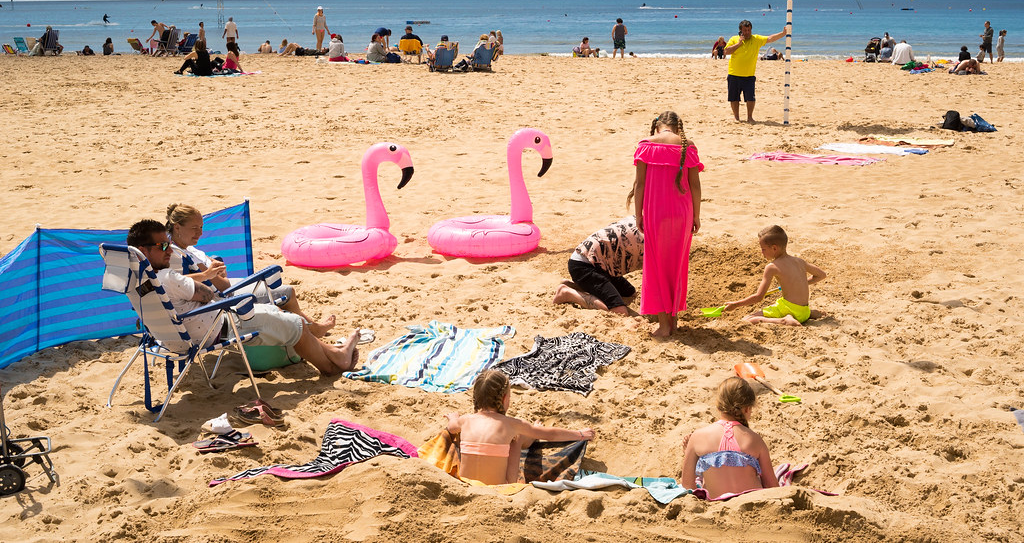

In [ ]:
#visualize sky detection
'''
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=2)
#out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
out = v.draw_panoptic_seg(outputs["panoptic_seg"][0].to("cpu"),outputs["panoptic_seg"][1])
cv2_imshow(out.get_image()[:, :, ::-1])
'''
# crop the sky in the original image
import numpy as np
id_mat=outputs["panoptic_seg"][0].to("cpu").numpy()

crop_i=0
for index in range(id_mat.shape[0]):

 if not (np.any(id_mat[index]==sky_id)):
  crop_i=index
  break
print('crop i is:',crop_i,id_mat.shape[0])

im=im[crop_i:,:]
cv2_imshow(im)

